<a href="https://colab.research.google.com/github/Geu-Pro2023/Sentiment_Analysis_Group12/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis Assignment on IMDB Reviews**

### **Group-12 Members**

---
1. ***Serge Kamanzi***
2. ***Geu Aguto Garang***
3. ***Ronald Aderinsola Abimbola***
4. ***Joak Buoy Gai***
---


# **Introduction**
#### **Objective:**
* Perform binary sentiment classification (positive/negative) on IMDB reviews.

#### **Models Compared:**
* **Machine Learning:** Logistic Regression (TF-IDF)
* **Deep Learning:** LSTM (Word Embeddings)
* **Evaluation Metrics:** Accuracy, F1-Score, Precision, Recall, ROC-AUC.

# **Dataset Description**

#### **Source:** IMDB 50K Movie Reviews (publicly available).

#### **Class Distribution:** Balanced (25K positive, 25K negative).

#### **Columns:**

1. review (text)
2. sentiment (label: positive/negative)

### **Import Libraries**

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## **Data Loading & Preprocessing**

### **Load Dataset**

In [23]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (50000, 2)


In [3]:
# Loading the dataset
file_path = "/content/IMDB Dataset.csv"
df = pd.read_csv(file_path, engine='python', on_bad_lines='warn')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### **Handle Missing Values**

In [24]:
# Verify dataset columns
print("Dataset Columns:", df.columns)

# Check for missing values
missing_values = df.isnull().sum()
missing_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values})
print("\nMissing Values:")
print(missing_df)

# Handle missing values
df['review'] = df['review'].fillna('')
df = df.dropna(subset=['sentiment'])

# Print dataset shape
print(f"Dataset shape: {df.shape}")

Dataset Columns: Index(['review', 'sentiment'], dtype='object')

Missing Values:
      Column  Missing Values
0     review               0
1  sentiment               0
Dataset shape: (50000, 2)


# **Exploratory Data Analysis (EDA)**

## **Visualizations**

### **1. Sentiment Distribution**

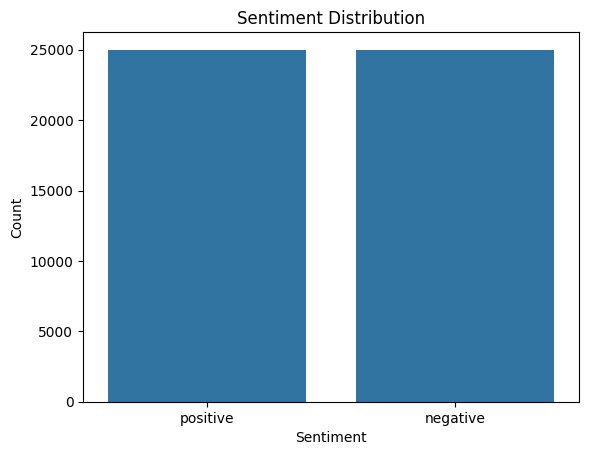

(50000, 3)

In [12]:
# Sentiment Distribution
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()
# Display dataset shape
df.shape

### **Explanation of insights**
#### The dataset is balanced, with roughly equal numbers of positive and negative reviews (25,000 each).There is no class imbalance. This is ideal for training classification models because it minimizes bias and reduces the need for resampling techniques like oversampling or undersampling.

## **2. Review Length Distribution**

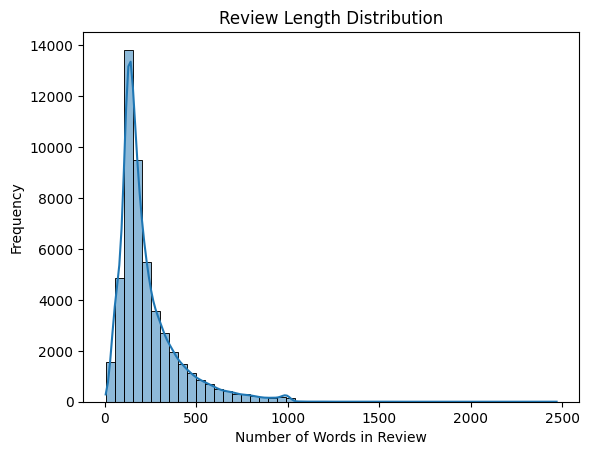

In [10]:
# Adding a column for review length
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Plott distribution of review lengths
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words in Review")
plt.ylabel("Frequency")
plt.show()

### **Expanation of insights**
#### Most reviews fall between 50 and 250 words. This helps us determine a reasonable maximum sequence length for text models. For example, in LSTM or BERT models, we might pad or truncate reviews to 200–250 words to ensure consistency in input shape

## **3. Word Cloud: Positive Reviews**




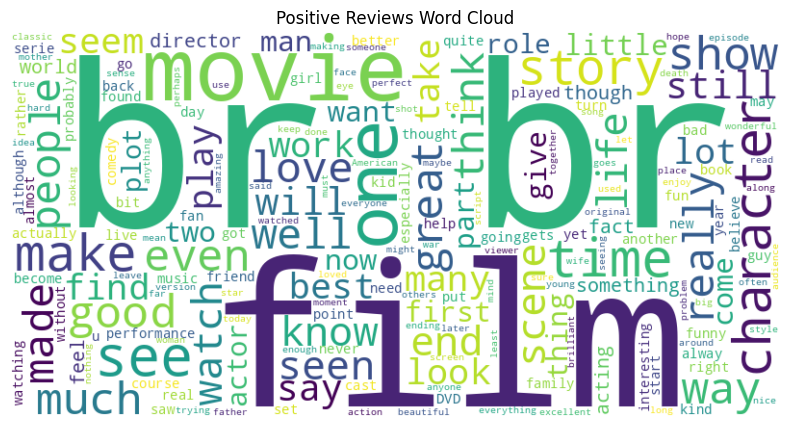

In [15]:
# Plotting Positive Reviews
pos_reviews = df[df['sentiment'] == 'positive']['review']
wordcloud_pos = WordCloud(background_color='white', width=800, height=400).generate(' '.join(pos_reviews))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews Word Cloud")
plt.show()

### **Expanation of insights**
#### Positive reviews frequently use words like “great”, “excellent”, “loved”, and “amazing”, showing a tendency to include emotionally charged and affirming adjectives. This highlights how strong emotion-based vocabulary correlates with positive sentiment.

## **4. Word Cloud: Negative Reviews**

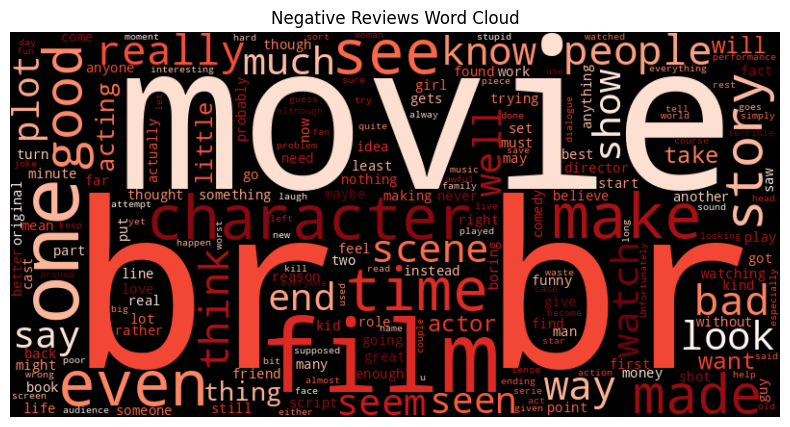

In [16]:
# Generating Negative Reviews
neg_reviews = df[df['sentiment'] == 'negative']['review']
wordcloud_neg = WordCloud(background_color='black', colormap='Reds', width=800, height=400).generate(' '.join(neg_reviews))

#Plottingh Negative Reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews Word Cloud")
plt.show()

### **Expanation of insights**
#### Negative reviews highlight words such as “bad”, “boring”, “waste”, and “worst”. These strong negative words clearly differentiate the sentiment and suggest that identifying such keywords can be effective for basic sentiment classification.

In [ ]:
Negative reviews highlight words such as “bad”, “boring”, “waste”, and “worst”. These strong negative words clearly differentiate the sentiment and suggest that identifying such keywords can be effective for basic sentiment classification.

## **5. Boxplot of Review Length by Sentiment**

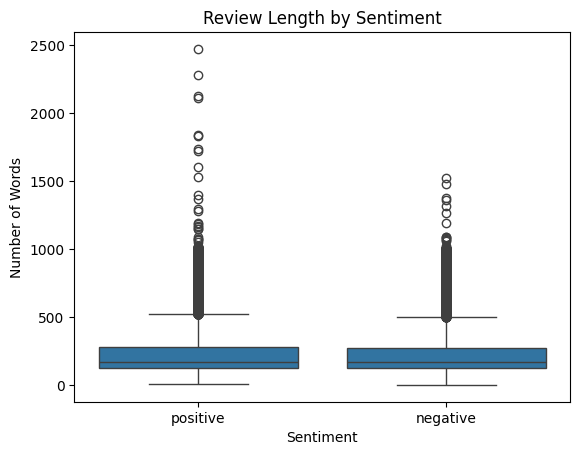

In [18]:
# Plotting Boxplot of Review Length
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title("Review Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.show()


###**Expanation of insights**
#### Positive reviews tend to be slightly longer and have more variation in length than negative ones. This may indicate that users who enjoy a movie write more detailed responses, while negative reviews might be more abrupt and concise.

# **Text Preprocessing**

In [29]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Keep only letters
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

df['cleaned_review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [31]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['sentiment'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
max_features = 5000
tfidf = TfidfVectorizer(max_features=max_features)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# **Feature Engineering**

### **TF-IDF for Logistic Regression:**

In [32]:
tfidf = TfidfVectorizer(max_features=5000)
X = df['cleaned_review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### **Word Embeddings for LSTM:**

In [33]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

# **Model Implementation**

## **1. Logistic Regression (Machine Learning)**

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)
best_lr = grid_search.best_estimator_
y_pred_lr = best_lr.predict(X_test_tfidf)

## **2. LSTM (Deep Learning)**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_lstm = Sequential([
    Embedding(10000, 128, input_length=200),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_lstm.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                        epochs=10, batch_size=64, callbacks=[EarlyStopping(patience=3)])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 188s 292ms/step - accuracy: 0.7485 - loss: 0.4921 - val_accuracy: 0.8668 - val_loss: 0.3310
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 216s 314ms/step - accuracy: 0.8826 - loss: 0.2947 - val_accuracy: 0.8770 - val_loss: 0.2952
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 204s 318ms/step - accuracy: 0.9117 - loss: 0.2358 - val_accuracy: 0.7098 - val_loss: 0.6703
Epoch 4/10
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9061 - loss: 0.2376

# **Experiment Tables**